In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit
from tqdm import tqdm

In [25]:
def nl(u_hat, alpha):
    u = np.fft.irfft2(u_hat)
    u_nl = alpha * u**2
    return np.fft.rfft2(u_nl)

def step(u, kx, ky, alpha, nu, nx, ny, dt):
    u_hat = np.fft.rfft2(u)
    u_hat_0 = u_hat.copy()
    for ord in [2, 1]:
        D = dt / ord
        u_nl_hat = nl(u_hat, alpha)
        u_hat = u_hat_0 - D * (nu * (kx**2 + ky**2) * u_hat + u_nl_hat - alpha * u_hat)
        u_hat[int(nx / 3):, int(ny / 3):] = 0
    return np.fft.irfft2(u_hat)


In [31]:
T = 1.0
dx = 0.1
dt = 0.001
image_path = "starrynight.jpg"
image = Image.open(image_path).convert("RGB")
u = np.array(image) / 255.0
ny, nx, _ = u.shape
alpha = 0.2
nu = 5e-5
kx = np.arange(0,nx/2+1)
ky = np.arange(0,ny/2+1)

ky, kx = np.meshgrid(ky, kx, indexing="ij")  # Create 2D wave number grids

def solve(u, kx, ky, alpha, nu, nx, ny, dt):
    u_r = u[..., 0]
    u_g = u[..., 1]
    u_b = u[..., 2]
    for n in tqdm(range(int(T/dt))):
        u_r = step(u_r, kx, ky, alpha, nu, nx, ny, dt)
        u_g = step(u_g, kx, ky, alpha, nu, nx, ny, dt)
        u_b = step(u_b, kx, ky, alpha, nu, nx, ny, dt)
        if n % 10 == 0:
            u = np.dstack([u_r, u_g, u_b])
            plt.imshow(u)
            plt.savefig(f'images/frame-{n}')

solve(u, kx, ky, alpha, nu, nx, ny, dt)


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (476,601) (950,601) 

 12%|█▏        | 116/1000 [01:32<11:45,  1.25it/s]


KeyboardInterrupt: 

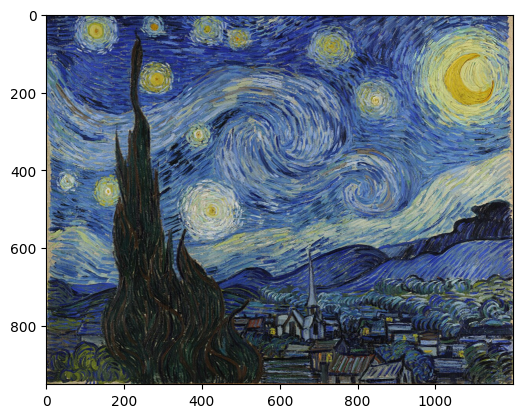

In [39]:
def nl(u_hat, alpha):
    u = np.fft.irfft2(u_hat)
    u_nl = alpha * u**2
    return np.fft.rfft2(u_nl)

def step(u, kx, ky, alpha, nu, nx, ny, dt):
    u_hat = np.fft.rfft2(u)
    u_hat_0 = u_hat.copy()
    for ord in [2, 1]:
        D = dt / ord
        u_nl_hat = nl(u_hat, alpha)
        u_hat = u_hat_0 - D * (nu * (kx**2 + ky**2) * u_hat + u_nl_hat - alpha * u_hat)
        u_hat[int(ny / 3):, int(nx // 2 / 3):] = 0
    return np.fft.irfft2(u_hat)

# Main script
T = 1.0
dx = 0.1
dt = 0.001
image_path = "starrynight.jpg"
image = Image.open(image_path).convert("RGB")
u = np.array(image) / 255.0
ny, nx, _ = u.shape
alpha = 0.2
nu = 5e-5

kx = np.fft.rfftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dx) * 2 * np.pi
ky, kx = np.meshgrid(ky, kx, indexing="ij")

def solve(u, kx, ky, alpha, nu, nx, ny, dt):
    u_r = u[..., 0]
    u_g = u[..., 1]
    u_b = u[..., 2]
    for n in tqdm(range(int(T / dt))):
        u_r = step(u_r, kx, ky, alpha, nu, nx, ny, dt)
        u_g = step(u_g, kx, ky, alpha, nu, nx, ny, dt)
        u_b = step(u_b, kx, ky, alpha, nu, nx, ny, dt)
        if n % 10 == 0:
            u = np.dstack([u_r, u_g, u_b])
            plt.imshow(u)
            plt.savefig(f'images/frame-{n:04d}.png')

solve(u, kx, ky, alpha, nu, nx, ny, dt)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from PIL import Image
from tqdm import tqdm

@jit(nopython=True, parallel=True)
def step(u, u_prev, c, dt, dx, dy):
    ny, nx, nc = u.shape
    u_next = np.zeros_like(u)
    coeff_x = (c * dt / dx)**2
    coeff_y = (c * dt / dy)**2

    for i in prange(1, ny - 1):
        for j in range(1, nx - 1):
            for k in range(nc):  # Parallelize the RGB channels
                u_next[i, j, k] = (
                    2 * u[i, j, k]
                    - u_prev[i, j, k]
                    + coeff_x * (u[i + 1, j, k] + u[i - 1, j, k] - 2 * u[i, j, k])
                    + coeff_y * (u[i, j + 1, k] + u[i, j - 1, k] - 2 * u[i, j, k])
                )
    return np.clip(u_next, 0, 1)

def solve_wave_vector(image_path, c, dt, dx, dy, T, save_interval=10):
    image = Image.open(image_path).convert("RGB")
    u = np.array(image, dtype=np.float64) / 255.0
    u_prev = u.copy()
    frames = int(T / dt)

    for n in tqdm(range(frames)):
        u_next = step(u, u_prev, c, dt, dx, dy)
        u_prev, u = u, u_next

        if n % save_interval == 0:
            plt.imshow(u)
            plt.axis("off")
            plt.title(f"Wave Equation at t={n * dt:.3f}")
            plt.savefig(f"images/frame-{n:04d}.png")
            plt.close()

# Parameters
dx = dy = 0.01
dt = 0.005
c = 1.0
T = 5.0
image_path = "starrynight.jpg"

# Solve the wave equation
solve_wave_vector(image_path, c, dt, dx, dy, T)


100%|██████████| 1000/1000 [01:16<00:00, 13.16it/s]
